In [144]:
import pandas as pd
import requests
import numpy as np
from scipy import optimize
import math
import json
import matplotlib.pyplot as plt
import arviz as az
import datetime

# Data

In [2]:
def extract_vo2(filename):
    r = requests.get(f'http://localhost:12021/Ryan%20Duecker/activity/{filename}')
    try:
        return json.loads(r.text)['RIDE']['TAGS']['VO2max detected']
    except:
        return 0

In [3]:
try:
    data_original = pd.read_csv('gc_activitydata_ryan.csv')
except:
    data_original = pd.read_csv(
        'http://localhost:12021/Ryan%20Duecker?metrics=Duration,TSS,StrydStress,Average_Heart_Rate,Max_Heartrate,Average_Power,Athlete_Weight,Estimated_VO2MAX,10_sec_Peak_Pace_Swim'
    )
    data_original.columns = [x.strip(' ') for x in data_original.columns]

    data_original['Sport'] = np.where(data_original['StrydStress']>0
                                 ,'Run'
                                 ,np.where(data_original['Average_Power']>0
                                     ,'Bike'
                                     ,np.where(data_original['10_sec_Peak_Pace_Swim']>0
                                         ,'Swim'
                                         ,'Other')))
    print('Gathering VO2max data')
    data_original['VO2max_Detected'] = data_original['filename'].apply(lambda x: extract_vo2(x))
    data_original['VO2max_Detected'] = data_original['VO2max_Detected'].astype(float)
    data_original.to_csv('gc_activitydata_ryan.csv', index=False)

In [109]:
# df = pd.read_csv('http://localhost:12021/Ryan%20Duecker?metrics=Duration')
# df.columns = [x.strip(' ') for x in df.columns]
# data_original = data_original.merge(df, on=['date','time','filename'], how='left')
# data_original.to_csv('gc_activitydata_ryan.csv', index=False)

# Analysis
___
## Helper Functions

In [222]:
def calc_vo2(row, max_hr, resting_hr):
    if row['Sport'] == 'Bike':
        percent_vo2 = (row['Average_Heart_Rate'] - resting_hr)/(max_hr - resting_hr)
        vo2_estimated = (((row['Average_Power']/75)*1000)/row['Athlete_Weight']) / percent_vo2
        # vo2_estimated = row['VO2max_Detected'] ## overide with Garmin VO2 Estimation
    elif row['Sport'] == 'Run':
        percent_vo2 = (row['Average_Heart_Rate'] - resting_hr)/(max_hr - resting_hr)
        vo2_estimated = (210/row['xPace']) / percent_vo2
    else:
        vo2_estimated =  0
    return vo2_estimated

In [232]:
def pre_process(data):
    data.rename(columns={'date':'workoutDate'}, inplace=True)
    data['day_TSS'] = data['TSS'].groupby(data['workoutDate']).transform('sum').fillna(0)
    data['VO2'] = data.apply(lambda row: calc_vo2(row, max_hr, resting_hr), axis=1)
    # data['VO2'] = np.where(data['Duration'] < 60*60, 0, data['VO2'])
    data['VO2'] = np.where(data['VO2'] < 1, 0, data['VO2'])
    
    data = data[['workoutDate','day_TSS','VO2']]
    data = data.groupby('workoutDate').mean()
    data['date'] = data.index
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(by=['date'])
    data.index = pd.DatetimeIndex(data['date'])
    missing_dates = pd.date_range(start=data.index.min(), end=data.index.max())
    data = data.reindex(missing_dates, fill_value=0)
    data['VO2'] = data['VO2'].replace(0,np.nan)
    data['VO2'] = data['VO2'].fillna(method='ffill')
    data = data.dropna()
    return data

In [233]:
data = data_original.copy()
data = pre_process(data)

In [234]:
data = data.reset_index()
data['week_start']  = data['index'].apply(lambda day_instance: day_instance - datetime.timedelta(days=day_instance.day_of_week))
data.set_index('index', inplace=True)

In [235]:
summary_data = data.groupby(['week_start']).agg({'day_TSS':'sum','VO2':'max'})

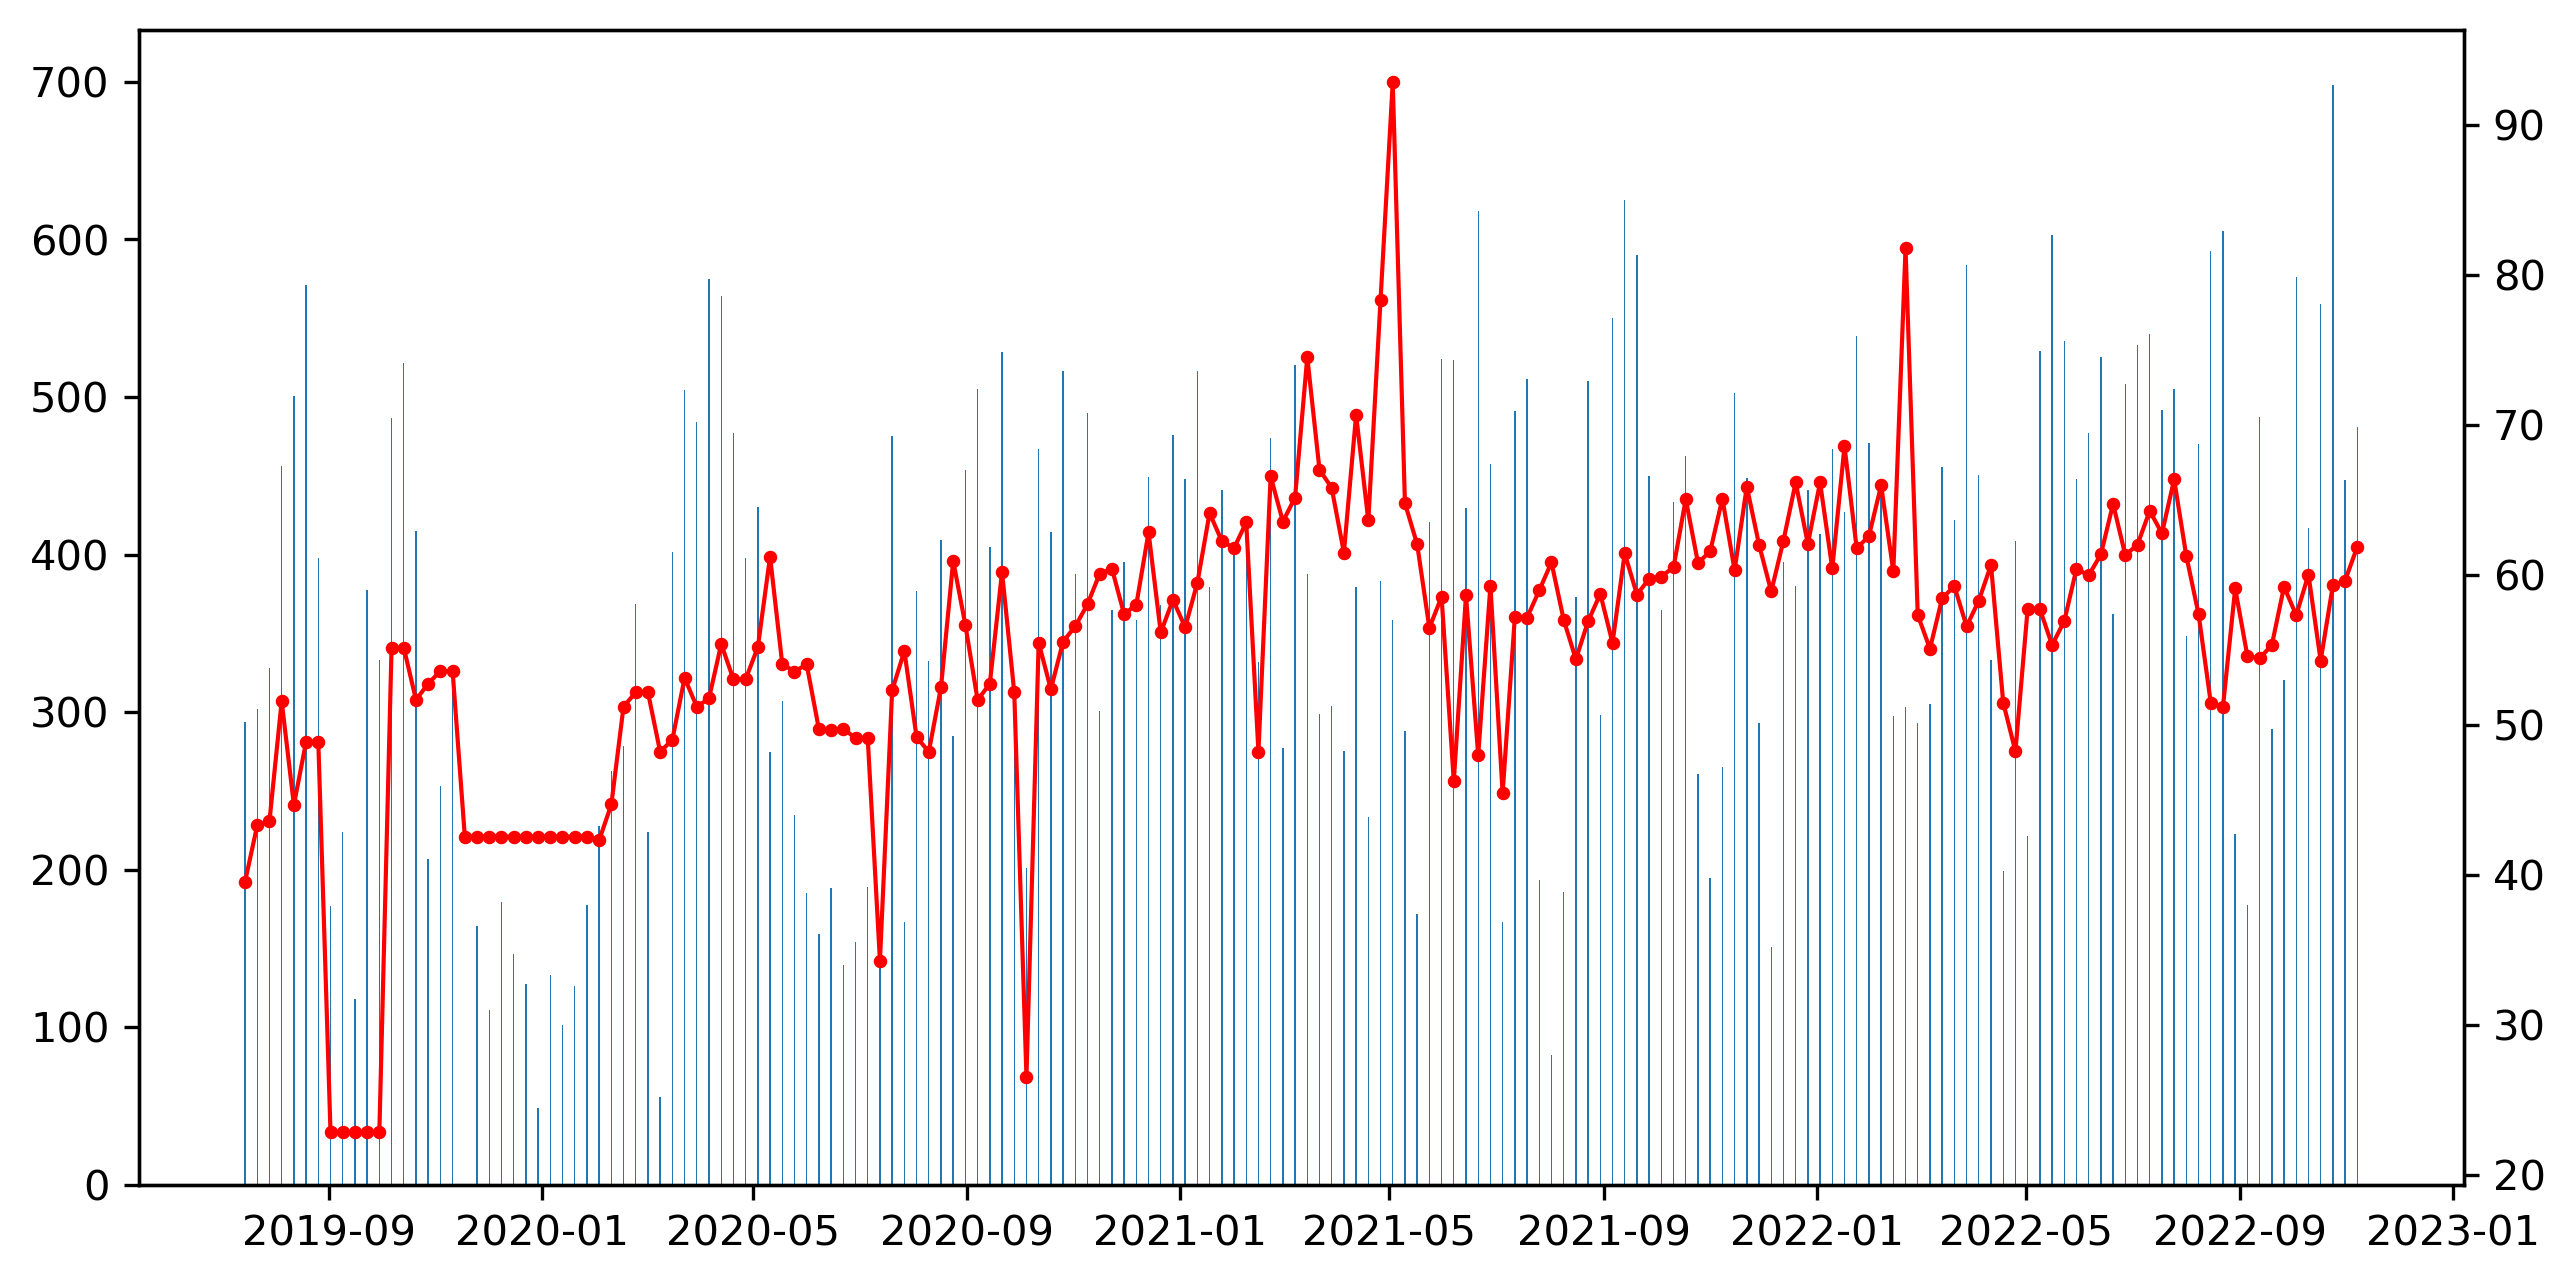

In [236]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=300)
ax.bar(summary_data.index, summary_data['day_TSS'])
ax1 = ax.twinx()
ax1.scatter(summary_data.index, summary_data['VO2'], s=5, label='VO2 est.', color='red')
ax1.plot(summary_data.index, summary_data['VO2'], ls='-', lw=1, color='red')

## Scipy Solver

In [93]:
max_hr = 185
resting_hr = 40
ctls_ref = 42
atls_ref = 7

In [228]:
def optimize_banister(params):
    data = data_original.copy()
    data = pre_process(data)
    
    TSS = data['day_TSS'].tolist()
    Performance = data['VO2'].tolist()
    losses = []
    ctls = atls = [0]
    for i in range(len(TSS)):
        ctl = (TSS[i] * (1-math.exp(-1/params[3]))) + (ctls[i] * (math.exp(-1/params[3])))
        atl = (TSS[i] * (1-math.exp(-1/params[4]))) + (atls[i] * (math.exp(-1/params[4])))
        ctls.append(ctl)
        atls.append(atl)
        Banister_Prediction = params[2] + params[0]*ctl - params[1]*atl
        loss = abs(Performance[i] - Banister_Prediction)
        losses.append(loss)

    MAE = np.mean(losses)
    return MAE

initial_guess  = [0.1, 0.5, 50, 45, 14]
individual_banister_model = optimize.minimize(optimize_banister
                                            ,x0=initial_guess
                                                    # k1,   k2,    p0,    CTLS,   ATLS
                                            ,bounds=[(0,1),(0,1),(20,50),(20,60),(5,20)])
print(individual_banister_model)

      fun: 9.973164926330082
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.20996569e-05, -3.44719808e-03,  8.28492761e-04,  2.16129319e-03,
       -6.74482636e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 396
      nit: 32
     njev: 66
   status: 0
  success: True
        x: array([ 1.        ,  0.2874484 , 37.26637164, 43.68611918, 20.        ])


## Bayes Solver

In [179]:
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample, Uniform, Beta

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [244]:
data = data_original.copy()
data = pre_process(data)
    
TSS = data['day_TSS'].tolist()
performance_kpi = data['VO2'].tolist()

def banister_regression(TSS, performance_kpi):
    with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        sigma = Normal("sigma", 0, sigma=5)

        p0 = Normal("p0", 55, sigma=7)
        ctls_mu = Normal("ctls_mu", 42, 2)
        atls_mu = Normal("atls_mu", 7, 1)
        ctls = Normal("ctls", ctls_mu, sigma=6)
        atls = Normal("atls", atls_mu, sigma=2.5)
        
        k1 = Beta("k1", alpha=1, beta=5) # guess == 0.1
        k2 = Beta("k2", alpha=3, beta=3) # guess == 0.5

        # Define likelihood
        banister_prediction = Normal("banister_prediction",
                                     mu=(p0 
                                         + k1 * (TSS * 1-pm.math.exp(-1/ctls))
                                         - k2 * (TSS * 1-pm.math.exp(-1/atls))
                                        )
                                    ,sigma=sigma
                                    ,observed=performance_kpi)
    return model

In [245]:
banister_model = banister_regression(TSS=TSS, performance_kpi=performance_kpi)

In [246]:
with banister_model:
    fit = pm.sample(2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p0, ctls_mu, atls_mu, ctls, atls, k1, k2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 88 seconds.


[Text(0.5, 1.0, 'Sigma Posterior'), Text(0.5, 0, 'Sigma')]

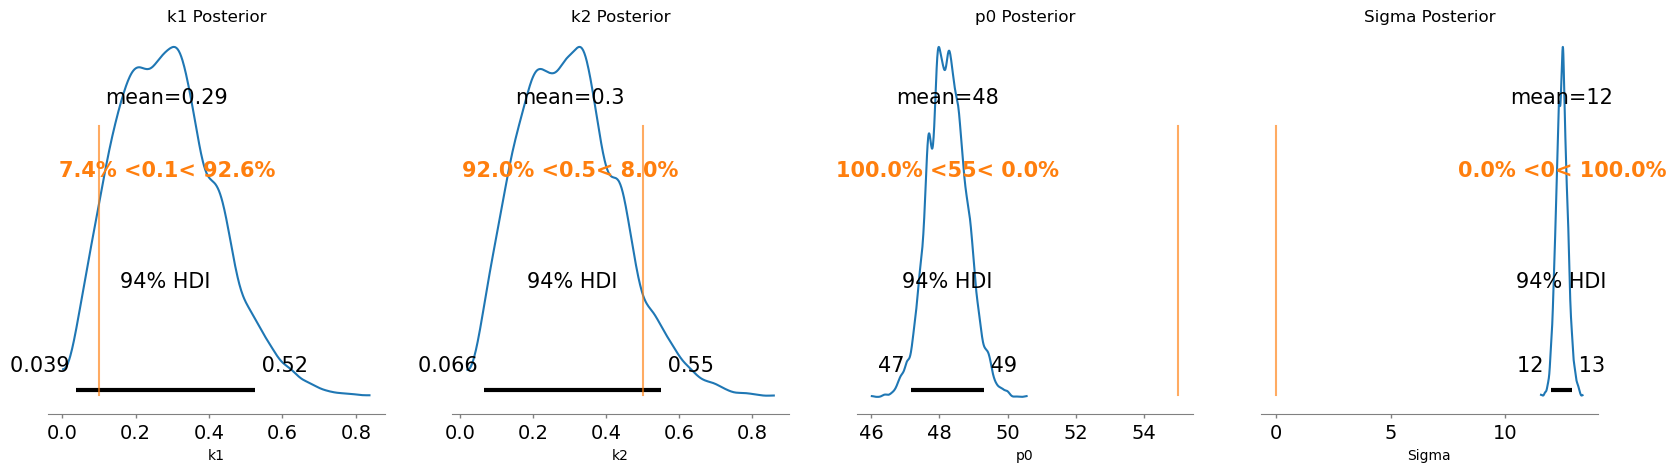

In [247]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

az.plot_posterior(fit, var_names=["k1"], ref_val=.1, ax=ax[0])
ax[0].set(title="k1 Posterior", xlabel="k1")

az.plot_posterior(fit, var_names=["k2"], ref_val=.5, ax=ax[1])
ax[1].set(title="k2 Posterior", xlabel="k2")

az.plot_posterior(fit, var_names=["p0"], ref_val=55, ax=ax[2])
ax[2].set(title="p0 Posterior", xlabel="p0")

az.plot_posterior(fit, var_names=["sigma"], ref_val=0, ax=ax[3])
ax[3].set(title="Sigma Posterior", xlabel="Sigma")

[Text(0.5, 1.0, 'ATLS Posterior'), Text(0.5, 0, 'ATLS')]

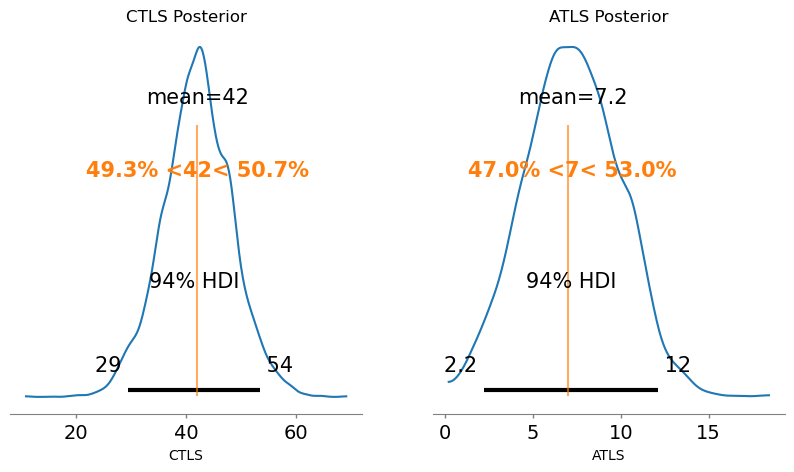

In [248]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

az.plot_posterior(fit, var_names=["ctls"], ref_val=ctls_ref, ax=ax[0])
ax[0].set(title="CTLS Posterior", xlabel="CTLS")

az.plot_posterior(fit, var_names=["atls"], ref_val=atls_ref, ax=ax[1])
ax[1].set(title="ATLS Posterior", xlabel="ATLS")

In [242]:
data = data_original.copy()
data = pre_process(data)
    
TSS = data['day_TSS'].tolist()
performance_kpi = data['VO2'].tolist()

def banister_regression(TSS, performance_kpi):
    with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        sigma = Normal("sigma", 0, sigma=5)

        p0 = Normal("p0", 55, sigma=7)
        ctls_mu = Normal("ctls_mu", 42, 2)
        atls_mu = Normal("atls_mu", 7, 1)
        ctls = Normal("ctls", ctls_mu, sigma=6)
        atls = Normal("atls", atls_mu, sigma=2.5)
        
        k1 = Beta("k1", alpha=1.3, beta=3) # guess == 0.1
        k2 = Beta("k2", alpha=3, beta=3) # guess == 0.5

        # Define likelihood
        banister_prediction = Normal("banister_prediction",
                                     mu=(p0 
                                         + k1 * (TSS * 1-pm.math.exp(-1/ctls))
                                         - k2 * (TSS * 1-pm.math.exp(-1/atls))
                                        )
                                    ,sigma=sigma)
    return model
banister_model = banister_regression(TSS=TSS, performance_kpi=performance_kpi)

In [243]:
pm.sample_prior_predictive(samples=1_000, model=banister_model)

Sampling: [atls, atls_mu, banister_prediction, ctls, ctls_mu, k1, k2, p0, sigma]


ValueError: scale < 0
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x27E4FDB6340>), TensorConstant{[]}, TensorConstant{11}, Elemwise{Composite{((i0 + (i1 * (i2 - i3))) - (i4 * (i2 - i5)))}}.0, sigma)
Toposort index: 16
Inputs types: [RandomGeneratorType, TensorType(int64, (0,)), TensorType(int64, ()), TensorType(float64, (1218,)), TensorType(float64, ())]
Inputs shapes: ['No shapes', (0,), (), (1218,), ()]
Inputs strides: ['No strides', (0,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x27E4FDB6340, array([], dtype=int64), array(11, dtype=int64), 'not shown', array(-0.76465338)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.